### Examples of how to use btk
This tutorial shows how the basic functions and usage of btk. For detailed information of teh btk pipline refer to the [User Guide](https://blendingtoolkit.readthedocs.io/en/latest/user_guide.html) on the package [website](https://blendingtoolkit.readthedocs.io/en/latest/index.html). 

First, we show how to generate images of galaxy blends with btk. These multi-band images can be produced with or without noise along with the isolated images of the galaxies in the blend. 

Then we show  how one can perform detection or deblending with btk. The user needs to input a btk.measure.Measurement_params class that contains functions to run the desired algorithm. Some example measurement classes can be found in btk/utils. In this notebook, we demonstare using btk with the following algorithms:
1. Finding local maxima (skimage.feature.peak_local_max)
2. SEP (Source Extractor in Python)
2. DM Stack (LSST Science Pipeline)
3. Scarlet (detection with SEP)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
import btk.plot_utils, btk.utils
import astropy.table

## Image generation with btk

### Draw blend images with noise

In [2]:
#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sample_input_catalog.fits')

# Load parame\ters
param = btk.config.Simulation_params(catalog_name, max_number=6, batch_size=4)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catalog(param)

#Generate catlogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

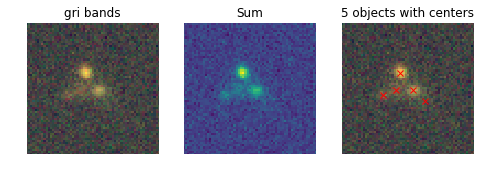

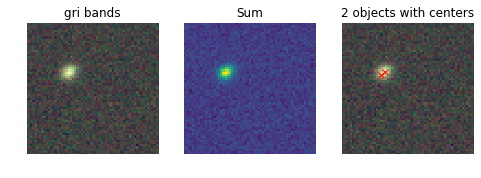

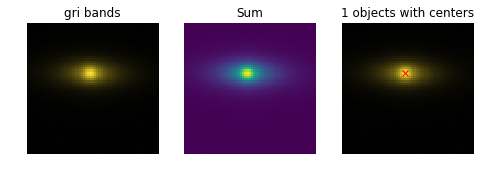

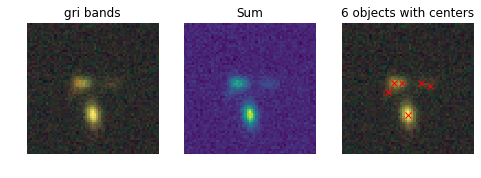

In [3]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']
# Plot blended images
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90))

### Draw isolated images of galaxies in blends. 
Here each galaxy in the blend is drawn in a separate postage stamp at the same location it was in the blend image

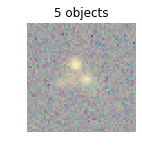

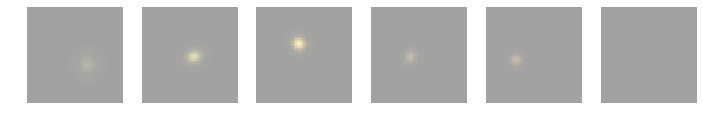

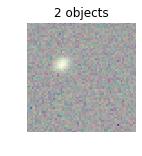

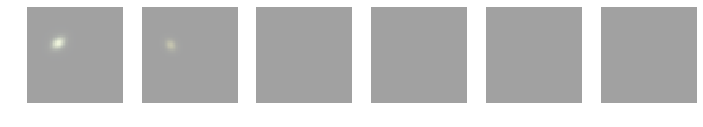

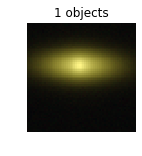

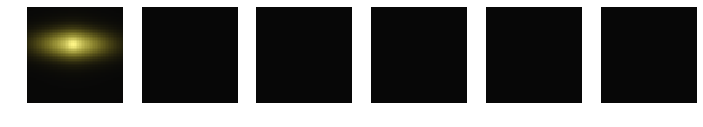

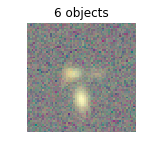

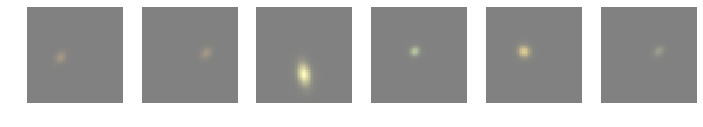

In [4]:
# Plot blended images and the individual objects
# Note: If scarlet is installed then Asinh mapping is used to display the images.
btk.plot_utils.plot_with_isolated(blend_images, isolated_images,blend_list, limits=(30,90))

### Running btk to output noiseless blend images

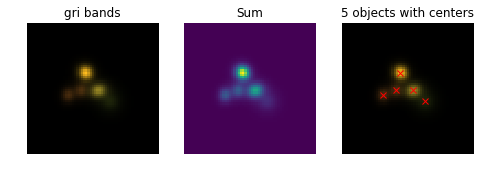

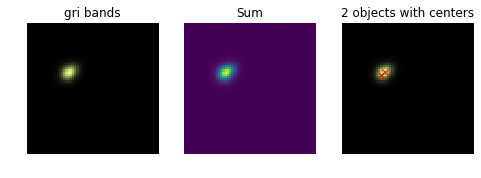

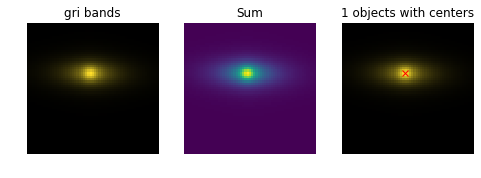

In [6]:
# add_noise set as False in the input config class 
param = btk.config.Simulation_params(catalog_name, max_number=6, batch_size=3, add_noise=False)
np.random.seed(param.seed)
catalog = btk.get_input_catalog.load_catalog(param)
blend_genrator = btk.create_blend_generator.generate(param, catalog)
observing_genrator = btk.create_observing_generator.generate(param)
draw_blend_generator = btk.draw_blends.generate(param, blend_genrator, observing_genrator)  

blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90))

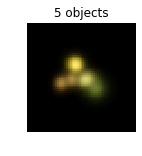

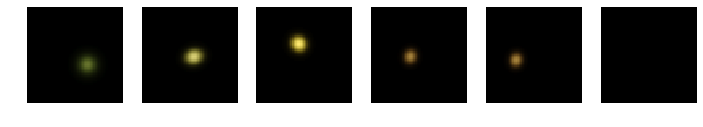

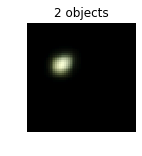

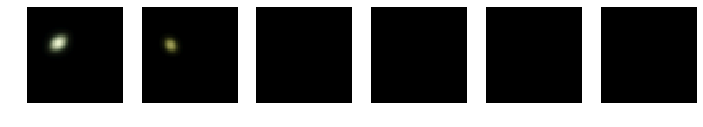

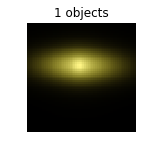

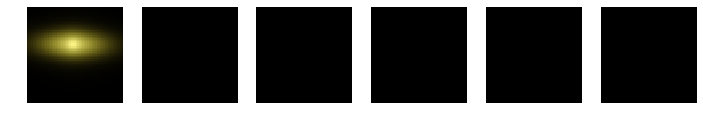

In [7]:
btk.plot_utils.plot_with_isolated(blend_images, isolated_images,blend_list, limits=(30,90))

We define a function to return draw_blend_generator so that we get the same datatset for different detection/deblending algorithms

In [8]:
def get_draw_blend_generator():
    # Load parameters
    #Input catalog name
    catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sample_input_catalog.fits')
    param = btk.config.Simulation_params(catalog_name,batch_size=4, max_number=6 )
    np.random.seed(param.seed)

    #Load input catalog
    catalog = btk.get_input_catalog.load_catalog(param)

    #Generate catlogs of blended objects 
    blend_generator = btk.create_blend_generator.generate(param, catalog)

    #Generates observing conditions for the selected survey_name and all input bands
    observing_generator = btk.create_observing_generator.generate(param)

    #Generate images of blends in all the observing bands
    draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator)
    return draw_blend_generator

## Running Detection algorithms with btk

### Finding local maxima with [scikit-image.peak_local_max](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html)

Note: This requires skimage to have been installed

Out of 5 objects, 3 detected, 2 undetected, & 0  spurious detections


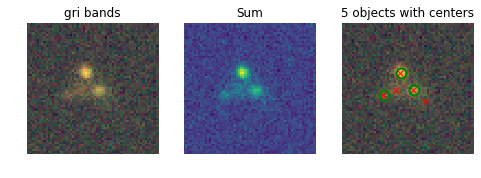

Out of 2 objects, 1 detected, 1 undetected, & 0  spurious detections


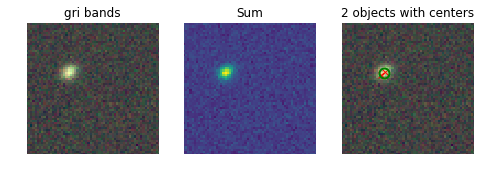

Out of 1 objects, 1 detected, 0 undetected, & 0  spurious detections


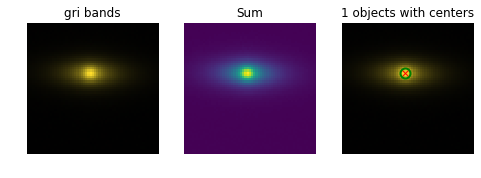

Out of 6 objects, 2 detected, 4 undetected, & 0  spurious detections


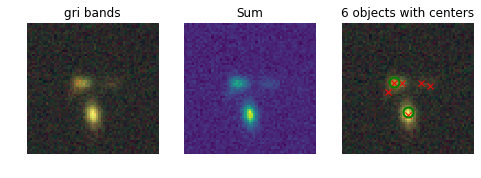

In [10]:
# Make measurement generator
# get class that describes how the measurement algorithm performs the measurement
meas_params = btk.utils.Basic_measure_params()
# get generator that yields measured values.
meas_generator = btk.measure.generate(
        meas_params, get_draw_blend_generator(), param)
output, deb, _ = next(meas_generator)
blend_list = output['blend_list']
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = deb[i]['peaks']
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    true_table = blend_list[i]
    det_table = astropy.table.Table(detected_centers, names=('dx', 'dy'))
    _, _, summary = btk.compute_metrics.evaluate_detection([true_table], [det_table], 0)
    det, undet, spur = summary[0][1:4]
    print("Out of %i objects, %i detected, %i undetected, & %i  spurious detections"%(len(true_centers), det, undet, spur))
    btk.plot_utils.plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))

### Perform detection with SEP (Source Extraction and Photometry in Python)
Note: This requires [sep](https://sep.readthedocs.io/en/v1.0.x/index.html#) to have been installed

Out of 5 objects, 4 detected, 1 undetected, & 0  spurious detections


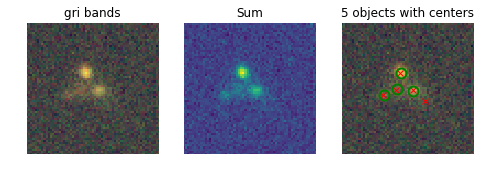

Out of 2 objects, 1 detected, 1 undetected, & 0  spurious detections


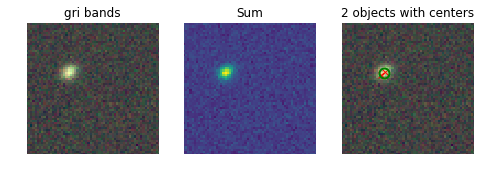

Out of 1 objects, 1 detected, 0 undetected, & 0  spurious detections


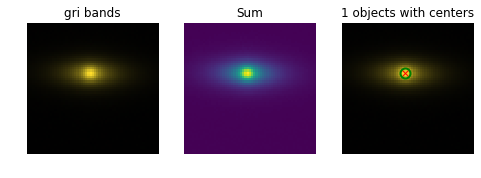

Out of 6 objects, 3 detected, 3 undetected, & 0  spurious detections


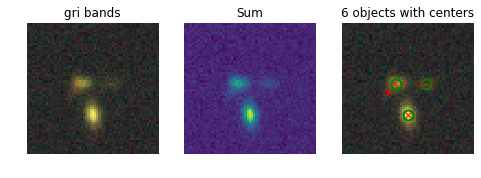

In [11]:
# Make measurement generator
# This is a class that describes how the measurement algorithm performs the measurement
meas_params = btk.utils.SEP_params()
# Get generator that yields the measured values.
meas_generator = btk.measure.generate(
        meas_params, get_draw_blend_generator(), param)
output, deb, _ = next(meas_generator)
blend_list = output['blend_list']
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = deb[i]['peaks']
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    true_table = blend_list[i]
    det_table = astropy.table.Table(detected_centers, names=('dx', 'dy'))
    _, _, summary = btk.compute_metrics.evaluate_detection([true_table], [det_table], 0)
    det, undet, spur = summary[0][1:4]
    print("Out of %i objects, %i detected, %i undetected, & %i  spurious detections"%(len(true_centers), det, undet, spur))
    btk.plot_utils.plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))

## Perform measurement with stack

Note: This requires DM stack to have been installed

Out of 5 objects, 4 detected, 1 undetected, & 0  spurious detections


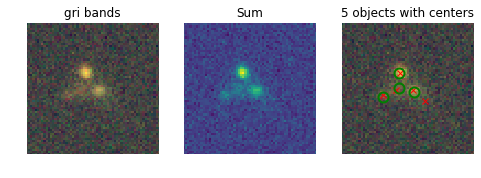

Out of 2 objects, 1 detected, 1 undetected, & 0  spurious detections


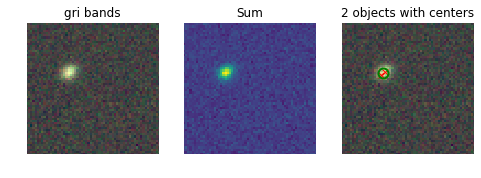

Out of 1 objects, 1 detected, 0 undetected, & 0  spurious detections


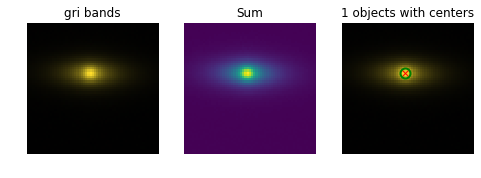

Out of 6 objects, 3 detected, 3 undetected, & 0  spurious detections


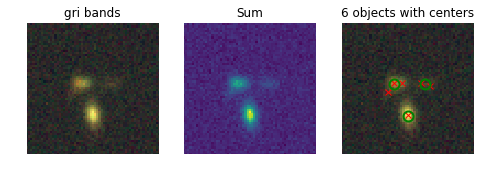

In [12]:
# Make measurement generator
# This is a class that describes how the measurement algorithm performs the measurement
meas_params = btk.utils.Stack_params()
meas_generator = btk.measure.generate(meas_params, get_draw_blend_generator(), param)
output, _, cat=next(meas_generator)
blend_list = output['blend_list']
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = np.array([cat[i]['base_NaiveCentroid_x'], cat[i]['base_NaiveCentroid_y']]).T
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    true_table = blend_list[i]
    det_table = astropy.table.Table(detected_centers, names=('dx', 'dy'))
    _, _, summary = btk.compute_metrics.evaluate_detection([true_table], [det_table], 0)
    det, undet, spur = summary[0][1:4]
    print("Out of %i objects, %i detected, %i undetected, & %i  spurious detections"%(len(true_centers), det, undet, spur))
    btk.plot_utils.plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))

## Running Deblending algorithms with btk

### Deblend with scarlet
Note: This requires scarlet and sep to have been installed

Here SEP first performs detection on the band-coadd image of teh blend.
Using these centers as centers, scarlet models the scene. The deblended galaxies are plotted below.

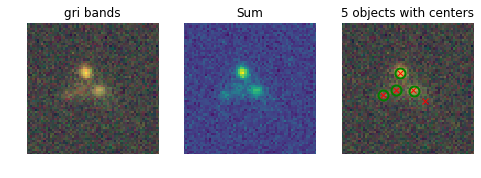

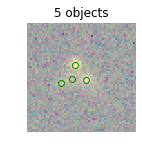

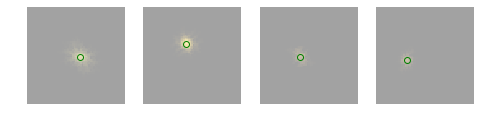

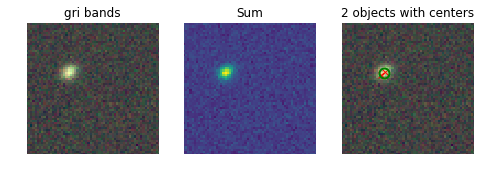

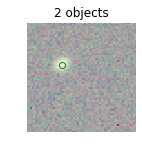

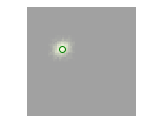

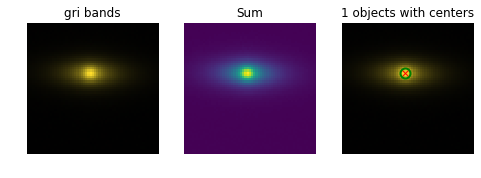

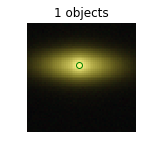

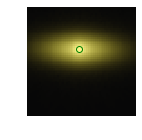

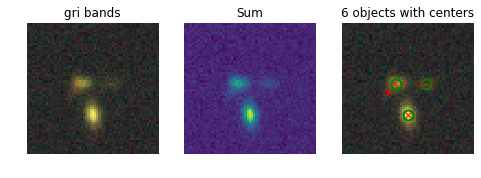

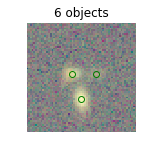

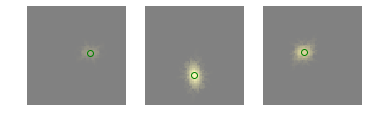

In [14]:
meas_params = btk.utils.Scarlet_params()
meas_generator = btk.measure.generate(
    meas_params, get_draw_blend_generator(), param)
output, deb,_ = next(meas_generator)
blend_list = output['blend_list']
blend_images = output['blend_images']
deblend_images = [deb[i]['deblend_image'] for i in range(len(blend_list))]
detected_centers = [deb[i]['peaks'] for i in range(len(blend_list))]
for i in range(len(blend_list)):
    btk.plot_utils.plot_blends(blend_images[i:i+1], blend_list[i:i+1], detected_centers[i:i+1],limits=(30,90))
    btk.plot_utils.plot_with_isolated(blend_images[i:i+1], deblend_images[i:i+1],
                                  blend_list[i:i+1], detected_centers[i:i+1],limits=(30,90))

### Other things you can do
## Draw segmentation map 

Segmentation map are identify pixels in the noiseless image that are above a certain threshold value.

In [15]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon
def plot_with_isolated_seg(blend_images, isolated_images, obs_condition,
                       blend_list, threshold =0.05, limits=None, detected_centers=None):
    """Plots blend images and isolated images of all objects in the blend as RGB(g,r,i) images
    Segmentation map corresponds to i band (noiseless) image and threshold
    """
    if detected_centers is None:
        detected_centers = [[]]*len(blend_list)
    for i in range(len(blend_list)): 
        bkgrnd = obs_condition[i][4].mean_sky_level**0.5 * threshold
        plt.figure(figsize=(2,2))
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        blend_img_rgb = btk.plot_utils.get_rgb_image(images)
        blend_no_noise = np.sum(isolated_images[i][:, :, :, 3], axis = 0)
        seg_map = btk.utils.make_true_seg_map(blend_no_noise, bkgrnd)
        contours = find_contours(seg_map, 0.5)
        for verts in contours:
            verts = np.fliplr(verts) 
            p = Polygon(verts, facecolor="none", edgecolor='r')
            ax = plt.gca()
            ax.add_patch(p)
        plt.imshow(blend_img_rgb)  
        plt.title("%i objects"%len(blend_list[i]))
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')
        for cent in detected_centers[i]:
            plt.plot(cent[0], cent[1],'go', fillstyle='none')
        plt.show()
        iso_blend = isolated_images[i]
        num = iso_blend.shape[0]
        plt.figure(figsize=(2*num, 2))
        for j in range(num): 
            iso_images = np.transpose(iso_blend[j, :, :, 1:4], axes=(2,0,1))
            iso_img_rgb = btk.plot_utils.get_rgb_image(iso_images, normalize_with_image=images)
            seg_map = btk.utils.make_true_seg_map(isolated_images[i][j, :, :, 3], bkgrnd)
            plt.subplot(1, num, j +1 )
            plt.imshow(iso_img_rgb)
            contours = find_contours(seg_map, 0.5)
            for verts in contours:
                verts = np.fliplr(verts)
                p = Polygon(verts, facecolor="none", edgecolor='r')
                ax = plt.gca()
                ax.add_patch(p) 
            if limits:
                plt.xlim(limits)
                plt.ylim(limits)
            plt.axis('off')
            if len(detected_centers[i]) > 0:
                plt.plot(detected_centers[i][j][0], detected_centers[i][j][1],'go', fillstyle='none')
        plt.show()


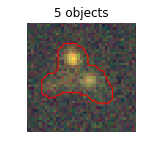

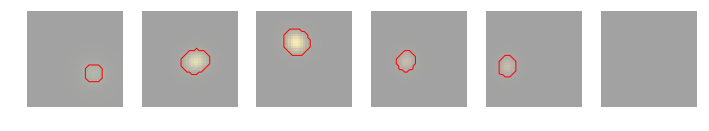

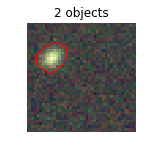

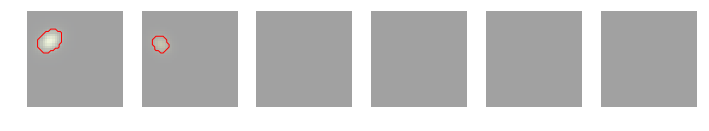

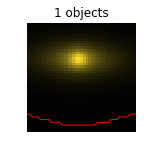

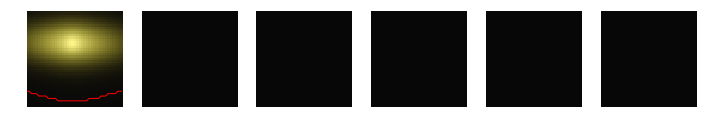

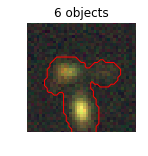

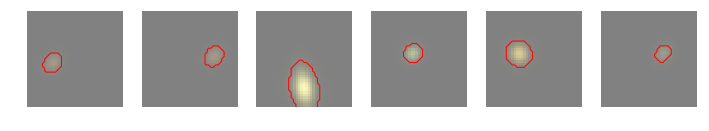

In [16]:

draw_blend_generator = get_draw_blend_generator()

blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']


# Segmentation threshold set at std of background in the i band. Segmentation defined for i band image
plot_with_isolated_seg(blend_images, isolated_images, output['obs_condition'],
                       blend_list, limits=(40,80), threshold=1)